In [ ]:
!pip install tensorflow librosa numpy pandas scikit-learn

In [47]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
def load_data(data_dirs):
    scaler = StandardScaler()
    labels = []
    features = []

    for data_dir in tqdm(data_dirs):
        for file in os.listdir(data_dir):
            if file.endswith('.wav'):
                # Load audio file
                file_path = os.path.join(data_dir, file)
                signal, sr = librosa.load(file_path, sr=22050)
                signal , _ = librosa.effects.trim(signal)
                # Extract features (MFCC)
                mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=50,n_fft=1024, hop_length=512)
                mfccs = np.mean(mfccs.T, axis=0)
                mfccs = mfccs.reshape(1, -1)
                mfccs_standardized = scaler.fit_transform(mfccs)
                features.append(mfccs)
                # Extract emotion label from filename (assumes format: xx-xx-xx-xx-xx-xx-xx.wav)
                emotion = file.split('-')[2]  # Adjust this based on your file naming convention
                labels.append(emotion)

    return np.array(features), np.array(labels)

# Load the dataset
actors = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']

data_dirs = []
for actor in actors:
    data_dirs.append(f'/content/drive/MyDrive/RAVDESS2/Actor_{actor}')

X, y = load_data(data_dirs)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1, random_state=2024)


100%|██████████| 24/24 [17:02<00:00, 42.62s/it]


In [61]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling1D, Input, LSTM, Dense, Dropout, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import SGD

def create_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # LSTM Layer
    lstm_out = LSTM(64, return_sequences=True)(inputs) #128
    lstm_out = Dropout(0.2)(lstm_out)
    # lstm_out = LSTM(128, return_sequences=True)(lstm_out) #128
    # lstm_out = Dropout(0.2)(lstm_out)
    # lstm_out = LayerNormalization(epsilon=1e-6)(lstm_out)

    # Transformer Layer
    for _ in range(4):

        attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(lstm_out, lstm_out)
        attention_output = LayerNormalization(epsilon=1e-6)(attention_output + lstm_out)
        attention_output = Dropout(0.2)(attention_output)
        ff_output  = Dense(512, activation='relu')(attention_output)
        ff_output  = Dropout(0.2)(ff_output)
        # ff_output  = Dense(512, activation='relu')(ff_output)
        # ff_output  = Dropout(0.1)(ff_output)
        # ff_output  = Dense(256, activation='relu')(ff_output)
        # ff_output  = Dropout(0.1)(ff_output)
        ff_output  = Dense(64, activation='relu')(ff_output)
        ff_output  = Dropout(0.2)(ff_output)
        #ff_output  = Dense(64)(ff_output)
        lstm_out = LayerNormalization(epsilon=1e-6)(attention_output + ff_output)

    lstm_out = Dropout(0.2)(lstm_out)

    # Fully Connected Layers
    flatten = tf.keras.layers.Flatten()(lstm_out)
    dense_out = Dense(64)(flatten)
    dense_out = Dropout(0.2)(dense_out)
    outputs = Dense(num_classes, activation='softmax')(dense_out)

    model = Model(inputs, outputs)
    return model

# Define model parameters
input_shape = (X_train.shape[2], 1)  # Adjust as needed
num_classes = len(np.unique(y_encoded))

# Create the model
model = create_model(input_shape, num_classes)
optimizer = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [62]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 50, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_8 (LSTM)             │ (None, 50, 64)         │         16,896 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_160 (Dropout)     │ (None, 50, 64)         │              0 │ lstm_8[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_32   │ (None, 50, 64)         │         66,368 │ dropout_160[0][0],     │
│ (MultiHeadAttention)      │                        │                │ dropout_160[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_64 (Add)              │ (None, 50, 64)         │              0 │ multi_head_attention_… │
│                           │                        │                │ dropout_160[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_64    │ (None, 50, 64)         │            128 │ add_64[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_162 (Dropout)     │ (None, 50, 64)         │              0 │ layer_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_80 (Dense)          │ (None, 50, 512)        │         33,280 │ dropout_162[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_163 (Dropout)     │ (None, 50, 512)        │              0 │ dense_80[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_81 (Dense)          │ (None, 50, 64)         │         32,832 │ dropout_163[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_164 (Dropout)     │ (None, 50, 64)         │              0 │ dense_81[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_65 (Add)              │ (None, 50, 64)         │              0 │ dropout_162[0][0],     │
│                           │                        │                │ dropout_164[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_65    │ (None, 50, 64)         │            128 │ add_65[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_33   │ (None, 50, 64)         │         66,368 │ layer_normalization_6… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_66 (Add)              │ (None, 50, 64)         │              0 │ multi_head_attention_… │
│                           │                        │                │ layer_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_6

 Total params: 753,224 (2.87 MB)

 Trainable params: 753,224 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# from tensorflow.keras.callbacks import TensorBoard

# Reshape data for LSTM input
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[2], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[2], 1))

# Create log directory
# log_dir = os.path.join("logs", "fit", "model")
# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=750, batch_size=60, validation_data=(X_test_reshaped, y_test))


Epoch 1/750
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.1470 - loss: 3.6172 - val_accuracy: 0.2014 - val_loss: 2.5639
Epoch 2/750
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1733 - loss: 3.1403 - val_accuracy: 0.2292 - val_loss: 2.2543
Epoch 3/750
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1824 - loss: 2.9342 - val_accuracy: 0.2708 - val_loss: 1.9945
Epoch 4/750
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1978 - loss: 2.6452 - val_accuracy: 0.2917 - val_loss: 2.0546
Epoch 5/750
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.2062 - loss: 2.6014 - val_accuracy: 0.2569 - val_loss: 2.0946
Epoch 6/750
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.2015 - loss: 2.4566 - val_accuracy: 0.2500 - val_loss: 2.0126
Epoch 7/750
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.2182 - loss: 2.4036 - val_accuracy: 0.2569 - val_loss: 1.9355
Epoch 8/750
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2284 - loss: 2.2022 - val_accuracy: 0.

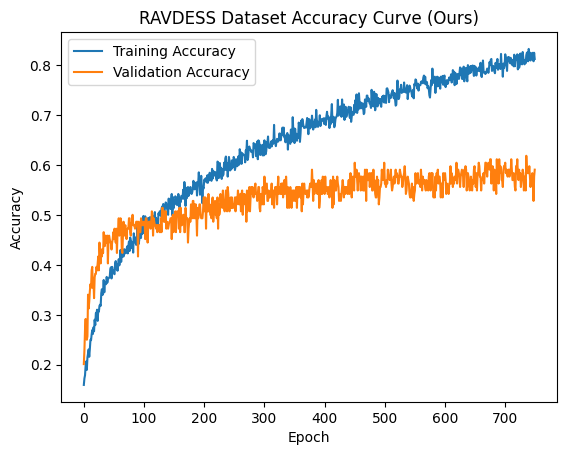

In [64]:
from matplotlib import pyplot as plt


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('RAVDESS Dataset Accuracy Curve (Ours)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

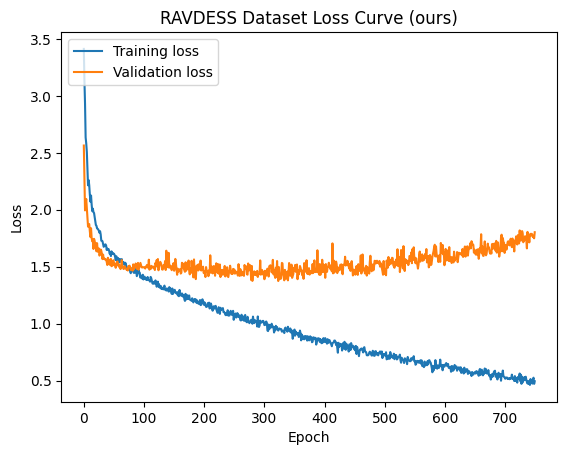

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('RAVDESS Dataset Loss Curve (ours)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper left')
plt.show()

In [66]:
y_pred = model.predict(X_test_reshaped)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step


<Axes: >

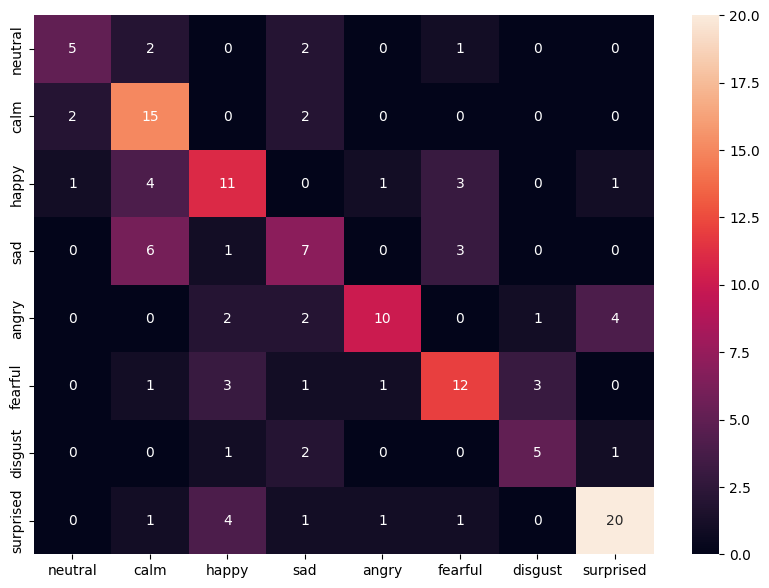

In [67]:
import sklearn.metrics as metrics
import seaborn as sn
import pandas as pd

confusion_emotions = ['neutral', 'calm', 'happy', 'sad','angry','fearful','disgust','surprised']
cm=metrics.confusion_matrix(y_test,np.argmax(y_pred,axis=-1))
df_cm=pd.DataFrame(cm,index=[i for i in confusion_emotions],columns=[i for i in confusion_emotions])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm,annot=True)

In [68]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6403 - loss: 1.5052 
Test Accuracy: 0.5903
